L'obiettivo del progetto è completare cifre minst di cui è visibile solo una metà. Anche la classe della cifra può essere utilizzata per la ricostruzione, se si ritiene utile.

In [509]:
import tensorflow as tf

In [510]:
from tensorflow.keras.layers import BatchNormalization, UpSampling2D, Input, Conv2D, Conv2DTranspose, Embedding, Flatten, Dense, Reshape, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist


In [511]:
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],28,28,1))
x_test = x_test.reshape((x_test.shape[0],28,28,1))

Verifichiamo shape e range dei dati.

In [512]:
print(x_train.shape)
print(x_train.min())
print(x_train.max())

(60000, 28, 28, 1)
0.0
1.0


Definiamo un semplice generatore che ritorna i valori di input e l'output atteso.

In [513]:
def generator(data,label,batchsize):
  x = np.zeros((batchsize,28,28,1))
  while True:
    batch_id = np.random.randint(0,data.shape[0],batchsize)
    x[:,:,:14] = data[batch_id,:,:14]
    yield (x,label[batch_id]),data[batch_id]

In [514]:
one_generator = generator(x_train,y_train,1)

Visualizziamo input e output atteso (ground truth)

In [515]:
import matplotlib.pyplot as plt

In [516]:
def plot_sample(x,lable,y):
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(x[:,:,0],cmap='gray')
  ax[0].set_title(f'Lable {lable}')
  ax[1].imshow(y[:,:,0],cmap='gray')
  ax[1].set_title('Ground Truth')
  plt.show()

(1, 28, 28, 1)


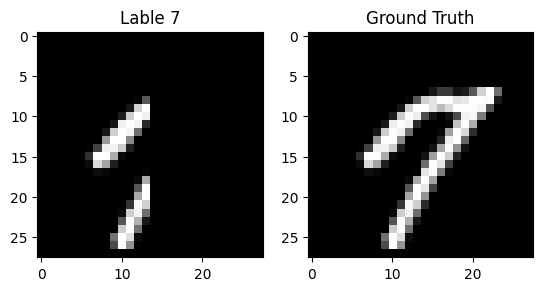

In [517]:
(x,l),y = next(one_generator)
print(x.shape)
plot_sample(x[0],l[0],y[0])

Definiamo una semplice baseline che completa la figura con una cifra "media".

In [518]:
mean_digit = np.zeros((10,28,28,1))
for i in range(10):
  mean_digit[i] = np.mean(x_train[y_train==i],axis=0)
#normalizaion
mean_digit = mean_digit - mean_digit.min()
mean_digit = mean_digit/mean_digit.max()

In [519]:
def baseline(x,l):
  res = np.copy(x)
  res[:,:,14:28] = mean_digit[l,:,14:28]
  return res

(1, 28, 28, 1)


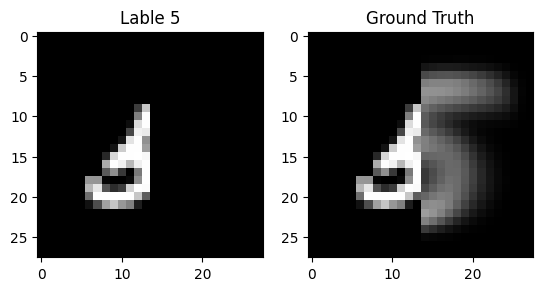

In [520]:
(x,l),y = next(one_generator)
print(x.shape)
plot_sample(x[0],l[0],baseline(x,l)[0])

Come metrica di valutazione usiamo mean squared error, ma al fine di meglio evidenziare il risultato consideriamo il rapporto con la baseline.

In [521]:
def evaluation(pred,l,y):
  res_baseline = baseline(y,l) #baseline for y or the input x is the same
  mse_baseline = np.mean((y-res_baseline)**2)
  mse = np.mean((y-pred)**2)
  print(mse)
  return mse/mse_baseline

Il miglior risultato possibile è 0 (match perfetto), e passando la baseline si ottiene 1. Valori inferiori a 1 sono insufficienti.

Restituire il risultato misurato su tutto il test_set.

Esempi:

In [522]:
evaluation(x_test,y_test,x_test)

0.0


np.float32(0.0)

In [523]:
test_baseline = baseline(x_test,y_test)

In [524]:
evaluation(test_baseline,y_test,x_test)

0.028651197


np.float32(1.0)

# Cosa consegnare

Dovete consegnare un solo notebook, con la vostra migliore soluzione in termini della metrica sopra definita. Se avete provato altre soluzioni potete discuterle brevemente.

Per il modello consegnato dovete fornire la traccia del training, ed eventualmente dei diagrammi della storia.

Rendete disponibili i pesi del modello mediante gdown. Predisponete il motebook in modo do poterli caricare.

Buon lavoro.

-------------------------------------------------------------------------------------------

Definisco un mse pesato, per dare più importanza alla colonna 14, la prima da completare. In questo modo garantisco che mantenga una coerenza iniziale durante la generazione, che verra mantenuta poi per le colonne successive.

In [525]:
def weighted_mse(y_true, y_pred):
    # Creo la maschera dei pesi
    # Prima metà (colonne 0-13) = 1.0
    first_half = tf.ones_like(y_true[:, :, :14, :])
    
    # Colonna 14 = peso 2
    col14 = tf.ones_like(y_true[:, :, 14:15, :]) * 2.0
    
    # Colonne 15-27 = peso 1
    rest = tf.ones_like(y_true[:, :, 15:, :])
    
    # Concateno lungo l'asse delle colonne (asse 2)
    mask = tf.concat([first_half, col14, rest], axis=2)
    
    # Calcolo il mse pesato
    return tf.reduce_mean(mask * tf.square(y_true - y_pred))


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_122            │ (None, 7, 7, 64)       │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_60 (UpSampling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_123            │ (None, 14, 14, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_61 (UpSampling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_124            │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,113 (727.00 KB)

 Trainable params: 185,665 (725.25 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.0334 - val_loss: 0.1139
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - loss: 0.0235 - val_loss: 0.1046
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 0.0218 - val_loss: 0.0310
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 0.0213 - val_loss: 0.0276
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - loss: 0.0205 - val_loss: 0.0245
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - loss: 0.0200 - val_loss: 0.0232
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - loss: 0.0193 - val_loss: 0.0250
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - loss: 0.0192 - val_loss: 0.0249
Epoch 9/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 120ms/step - loss: 0.0192 - val_loss: 0.0231
Epoch 10/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 0.0189 - val_loss: 0.0231
Epoch 11/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - loss: 0.0185 - val_loss: 0.0236
Epoch 12/15
200/200

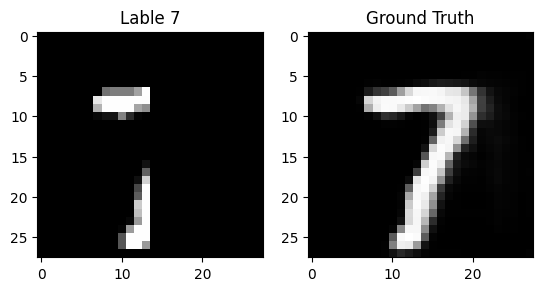

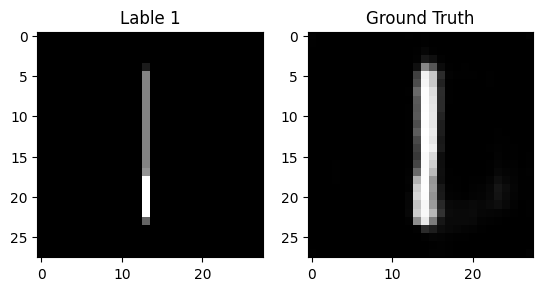

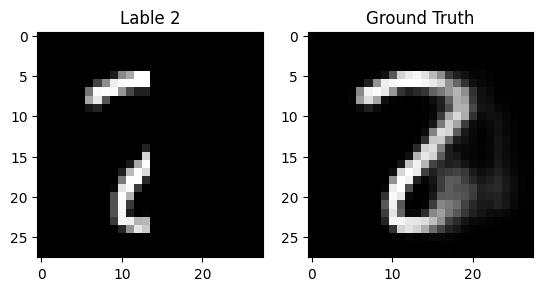

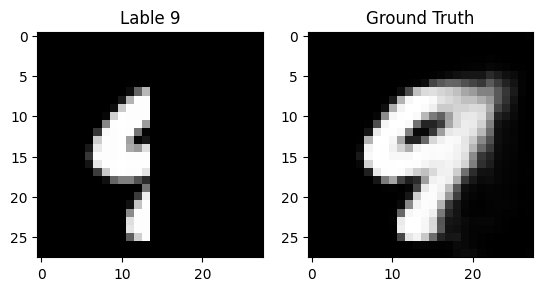

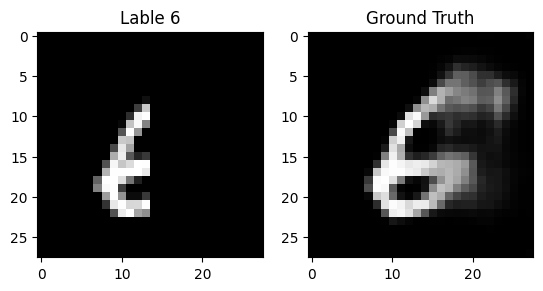

0.014952169


np.float32(0.52218884)

In [526]:
# ===========================
# 1. Definizione del modello
# ===========================

input_img = Input(shape=(28,28,1))

x = Conv2D(32, 3, strides=2, activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)

x = Conv2D(64, 3, strides=2, activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# ----- DECODER -----
x = Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

output_img = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss=weighted_mse)  # MSE come richiesto
autoencoder.summary()

# ===========================
# 2. Training
# ===========================

# Creiamo un generator con batch size 32
train_gen = generator(x_train, y_train, batchsize=32)
val_gen = generator(x_test, y_test, batchsize=32)

# Creiamo un generatore wrapper che estrae solo l'input immagine
def fit_generator(gen):
    while True:
        (x, l), y = next(gen)
        yield x, y
# Alleniamo il modello

history = autoencoder.fit(
    fit_generator(train_gen),
    steps_per_epoch=200,
    epochs=15,
    validation_data=fit_generator(val_gen),
    validation_steps=50
)

# ===========================
# 3. Valutazione
# ===========================

# Prendiamo alcune immagini di test
(x_batch, l_batch), y_batch = next(generator(x_test, y_test, batchsize=10))
pred_batch = autoencoder.predict(x_batch)

# Visualizziamo i risultati
for i in range(5):
    plot_sample(x_batch[i], l_batch[i], pred_batch[i])

# Calcoliamo la metrica rispetto alla baseline
evaluation(pred_batch, l_batch, y_batch)
